In [205]:
import os
import networkx as nx
import datetime
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from nestedness_calculator import NestednessCalculator
import csv

from utils_graph_generation import get_paths,load_graph
from utils_graph_metrics import tresh_normalization, calc_avg_degree, convert_keys_to_float


In [206]:
def calc_nestedness(G):
    mat = nx.to_numpy_array(G, weight=None)
    mat = mat[~np.all(mat == 0, axis=1)]
    mat = mat[:,~np.all(mat == 0, axis=0)]
    nodf_score = NestednessCalculator(mat).nodf(mat)
    return nodf_score

In [207]:
MANIFESTACION = "9n"   
MODE = "bipartite"
HORAS_HUMANAS = False

if MODE == "hashtag":
    suffix = 'h'
elif MODE == "user":
    suffix = 'u'
elif MODE == "bipartite":
    suffix = 'b'


graphs_folder, plots_folder, _ = get_paths(MODE, MANIFESTACION)
measures_name = "measures/" + MANIFESTACION + '_' + suffix + '.json'


In [208]:
dict_manif = {}

# Intentamos cargar el archivo donde volcar los datos
if os.path.exists(measures_name):
    try:
        with open(measures_name, 'r') as f:
            dict_manif = json.load(f)
        dict_manif = convert_keys_to_float(dict_manif, recursive=False, tipo="int")
    except json.JSONDecodeError:
        dict_manif = {}

dict_file = {}
with open("data/" + MANIFESTACION + ".txt", "r") as file:
    df = pd.read_csv(file, sep=' ')
horas = df["hour"].unique()

for hora in tqdm(horas):
    hora = int(hora)
    if not hora in dict_manif.keys():
        dict_manif[hora] = {}

    G = nx.read_gexf("graphs2/" + 'nodes_' + MODE + '/' + MANIFESTACION + '/' + str(hora) + '.gexf')
    if not "nestedness" in dict_manif[hora].keys():
        nestedness = calc_nestedness(G)
        dict_manif[hora]["nestedness"] = float(nestedness)

    if not "clustering" in dict_manif[hora].keys():
        if MODE == "bipartite":
            avg_clust=bipartite.average_clustering(G)
        else:
            avg_clust=nx.average_clustering(G)
            
        dict_manif[hora]["clustering"] = avg_clust
    
    if not "modularity" in dict_manif[hora].keys(): 
        modularity_louv = nx.community.modularity(G, nx.community.louvain_communities(G, seed=123))
        dict_manif[hora]["modularity"] = modularity_louv
    
    if not "num_nodes" in dict_manif[hora].keys(): 
        dict_manif[hora]["num_nodes"] = float(G.number_of_nodes())

    if not "num_edges" in dict_manif[hora].keys(): 
        dict_manif[hora]["num_edges"] = float(G.number_of_edges())

    with open(measures_name, 'w') as f:
            json.dump(dict_manif, f, indent=2)

  0%|          | 0/97 [00:00<?, ?it/s]

100%|██████████| 97/97 [00:07<00:00, 13.46it/s]


In [209]:
arr_hour =[]
arr_clust = []
arr_nest = []
arr_mod = []
arr_nodes = []
for k in dict_manif.keys():
    arr_hour.append(str(k))
    arr_nest.append(dict_manif[k]["nestedness"])
    arr_mod.append(dict_manif[k]["modularity"])
    arr_clust.append(dict_manif[k]["clustering"])
    arr_nodes.append(dict_manif[k]["num_nodes"])


In [210]:
data = list(zip(arr_hour, arr_clust, arr_mod, arr_nest, arr_nodes))
data.sort()
hour_sort, clust_sort, mod_sort, nest_sort, nodes_sort = zip(*data)
hour_sort = list(hour_sort)
clust_sort = list(clust_sort)
mod_sort = list(mod_sort)
nest_sort = list(nest_sort)
nodes_sort = list(nodes_sort)

In [211]:
dt_sort_arr=[]
for hour in hour_sort:
    if HORAS_HUMANAS:
        dt_sort_arr.append(datetime.datetime.fromtimestamp(int(hour)*3600, tz=datetime.timezone.utc))
    else:
        dt_sort_arr.append(int(hour))
print(MANIFESTACION, ", hora con avg_clust max", dt_sort_arr[clust_sort.index(max(clust_sort))], "hour_name:", hour_sort[clust_sort.index(max(clust_sort))])
print(MANIFESTACION, ", hora con avg_clust min", dt_sort_arr[clust_sort.index(min(clust_sort))], "hour_name:", hour_sort[clust_sort.index(min(clust_sort))])

print(MANIFESTACION, ", hora con modularity max", dt_sort_arr[mod_sort.index(max(mod_sort))], "hour_name:", hour_sort[mod_sort.index(max(mod_sort))])
print(MANIFESTACION, ", hora con modularity min", dt_sort_arr[mod_sort.index(min(mod_sort))], "hour_name:", hour_sort[mod_sort.index(min(mod_sort))])

print(MANIFESTACION, ", hora con nestedness max", dt_sort_arr[nest_sort.index(max(nest_sort))], "hour_name:", hour_sort[nest_sort.index(max(nest_sort))])
print(MANIFESTACION, ", hora con nestedness min", dt_sort_arr[nest_sort.index(min(nest_sort))], "hour_name:", hour_sort[nest_sort.index(min(nest_sort))])

9n , hora con avg_clust max 437024 hour_name: 437024
9n , hora con avg_clust min 436983 hour_name: 436983
9n , hora con modularity max 436983 hour_name: 436983
9n , hora con modularity min 437037 hour_name: 437037
9n , hora con nestedness max 437037 hour_name: 437037
9n , hora con nestedness min 436983 hour_name: 436983


Fecha (utc) identificada en paper para 9n 2019-11-09 21:00:00+00:00
Fecha (utc) inicial en paper 436999 , fecha final en paper 437057


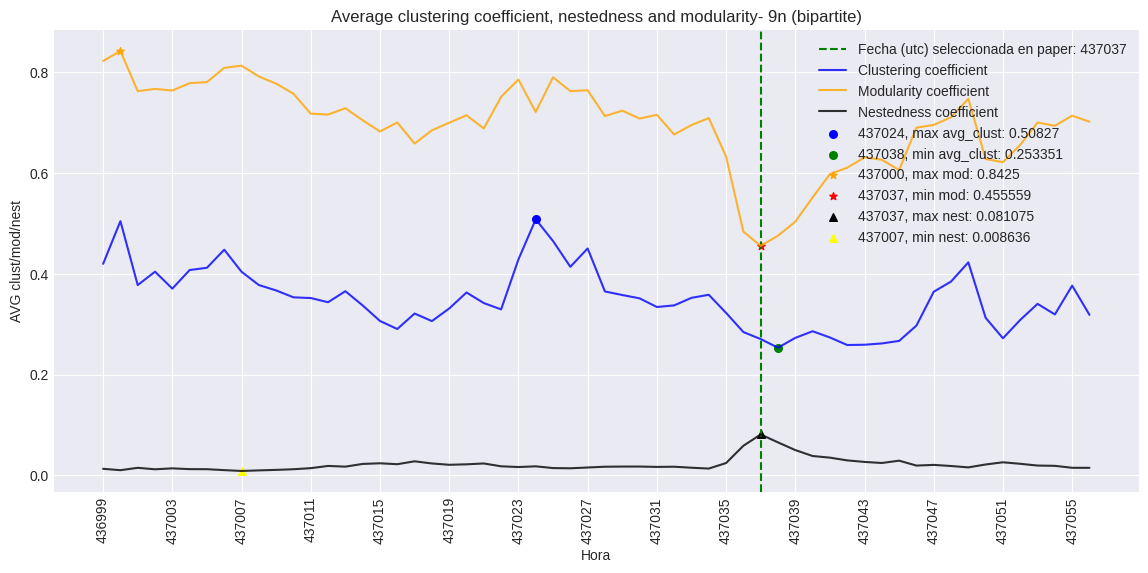

In [212]:
if MANIFESTACION == "9n":
        fecha=str(int(437037))
        index_fecha=hour_sort.index(fecha)
        init=str(int(1573196400/3600))
        index_init=hour_sort.index(init)
        end=str(int(1573405200/3600))
        index_end=hour_sort.index(end)
else:
        fecha=str(int(429624))
        index_fecha=hour_sort.index(fecha)
        init=str(int(429531))
        index_init=hour_sort.index(init)
        end=str(int(1546902000/3600))
        index_end=hour_sort.index(end)
print("Fecha (utc) identificada en paper para", MANIFESTACION, datetime.datetime.fromtimestamp(int(fecha)*3600, tz=datetime.timezone.utc))
print("Fecha (utc) inicial en paper", dt_sort_arr[index_init], ", fecha final en paper", dt_sort_arr[index_end])
plt.figure(figsize=(14,6)) 
plt.style.use('seaborn-v0_8-darkgrid')    

if HORAS_HUMANAS:
        plt.axvline(x=dt_sort_arr[index_fecha], color="green", ls="--", label="Fecha (utc) seleccionada en paper: " + str(datetime.datetime.fromtimestamp(int(fecha)*3600, tz=datetime.timezone.utc)))
else:
        plt.axvline(x=dt_sort_arr[index_fecha], color="green", ls="--", label="Fecha (utc) seleccionada en paper: " + str(fecha))



plt.plot(dt_sort_arr[index_init:index_end], clust_sort[index_init:index_end], alpha=0.8, c="blue", label="Clustering coefficient")
plt.plot(dt_sort_arr[index_init:index_end], mod_sort[index_init:index_end], alpha=0.8, c="orange", label="Modularity coefficient")
plt.plot(dt_sort_arr[index_init:index_end], nest_sort[index_init:index_end], alpha=0.8, c="black", label="Nestedness coefficient")
#plt.scatter(dt_sort_arr, nest_sort)

name_max_clust = str(dt_sort_arr[index_init:index_end][clust_sort[index_init:index_end].index(max(clust_sort[index_init:index_end]))]) + ", max avg_clust: " + str(round(max(clust_sort[index_init:index_end]), 6))
name_min_clust  = str(dt_sort_arr[index_init:index_end][clust_sort[index_init:index_end].index(min(clust_sort[index_init:index_end]))]) + ", min avg_clust: " + str(round(min(clust_sort[index_init:index_end]), 6))
plt.scatter(dt_sort_arr[index_init:index_end][clust_sort[index_init:index_end].index(max(clust_sort[index_init:index_end]))], max(clust_sort[index_init:index_end]), s=30, c="blue", marker="o", label = name_max_clust)
plt.scatter(dt_sort_arr[index_init:index_end][clust_sort[index_init:index_end].index(min(clust_sort[index_init:index_end]))], min(clust_sort[index_init:index_end]), s=30, c="green", marker="o", label = name_min_clust)

name_max_mod = str(dt_sort_arr[index_init:index_end][mod_sort[index_init:index_end].index(max(mod_sort[index_init:index_end]))]) + ", max mod: " + str(round(max(mod_sort[index_init:index_end]), 6))
name_min_mod  = str(dt_sort_arr[index_init:index_end][mod_sort[index_init:index_end].index(min(mod_sort[index_init:index_end]))]) + ", min mod: " + str(round(min(mod_sort[index_init:index_end]), 6))
plt.scatter(dt_sort_arr[index_init:index_end][mod_sort[index_init:index_end].index(max(mod_sort[index_init:index_end]))], max(mod_sort[index_init:index_end]), s=30, c="orange", marker="*", label = name_max_mod)
plt.scatter(dt_sort_arr[index_init:index_end][mod_sort[index_init:index_end].index(min(mod_sort[index_init:index_end]))], min(mod_sort[index_init:index_end]), s=30, c="red", marker="*", label = name_min_mod)
#plt.plot(points[0], points[1], alpha=alpha, label="K_T = " + str(arr_kt_plot[index]))

name_max_nest = str(dt_sort_arr[index_init:index_end][nest_sort[index_init:index_end].index(max(nest_sort[index_init:index_end]))]) + ", max nest: " + str(round(max(nest_sort[index_init:index_end]), 6))
name_min_nest  = str(dt_sort_arr[index_init:index_end][nest_sort[index_init:index_end].index(min(nest_sort[index_init:index_end]))]) + ", min nest: " + str(round(min(nest_sort[index_init:index_end]), 6))
plt.scatter(dt_sort_arr[index_init:index_end][nest_sort[index_init:index_end].index(max(nest_sort[index_init:index_end]))], max(nest_sort[index_init:index_end]), s=30, c="black", marker="^", label = name_max_nest)
plt.scatter(dt_sort_arr[index_init:index_end][nest_sort[index_init:index_end].index(min(nest_sort[index_init:index_end]))], min(nest_sort[index_init:index_end]), s=30, c="yellow", marker="^", label = name_min_nest)

plt.xlabel("Hora")
plt.ylabel("AVG clust/mod/nest")
plt.xticks(dt_sort_arr[index_init:index_end][::4], labels=dt_sort_arr[index_init:index_end][::4])
plt.xticks(rotation=90)
plt.title("Average clustering coefficient, nestedness and modularity- " + MANIFESTACION + ' (' + MODE + ')')
plt.legend()

plt.savefig("plots/paper_avg_clust_mod_nest_" + MANIFESTACION + '_' + suffix , bbox_inches = "tight")

plt.show()


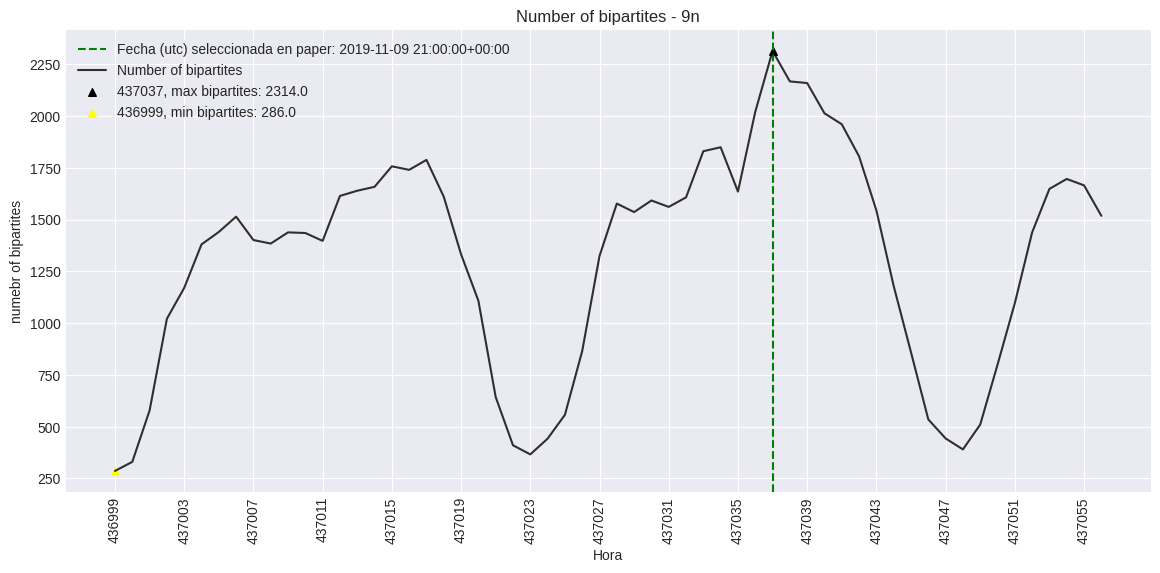

In [213]:
plt.figure(figsize=(14,6)) 
plt.style.use('seaborn-v0_8-darkgrid')    

plt.axvline(x=dt_sort_arr[index_fecha], color="green", ls="--", label="Fecha (utc) seleccionada en paper: " + str(datetime.datetime.fromtimestamp(int(fecha)*3600, tz=datetime.timezone.utc)))

plt.plot(dt_sort_arr[index_init:index_end], nodes_sort[index_init:index_end], alpha=0.8, c="black", label="Number of " + MODE + 's')

name_max_nodes = str(dt_sort_arr[index_init:index_end][nodes_sort[index_init:index_end].index(max(nodes_sort[index_init:index_end]))]) + ", max " + MODE + "s: " + str(round(max(nodes_sort[index_init:index_end]), 6))
name_min_nodes  = str(dt_sort_arr[index_init:index_end][nodes_sort[index_init:index_end].index(min(nodes_sort[index_init:index_end]))]) + ", min " + MODE + "s: " + str(round(min(nodes_sort[index_init:index_end]), 6))
plt.scatter(dt_sort_arr[index_init:index_end][nodes_sort[index_init:index_end].index(max(nodes_sort[index_init:index_end]))], max(nodes_sort[index_init:index_end]), s=30, c="black", marker="^", label = name_max_nodes)
plt.scatter(dt_sort_arr[index_init:index_end][nodes_sort[index_init:index_end].index(min(nodes_sort[index_init:index_end]))], min(nodes_sort[index_init:index_end]), s=30, c="yellow", marker="^", label = name_min_nodes)
   
plt.xlabel("Hora")
plt.ylabel("numebr of " + MODE + 's')
plt.xticks(dt_sort_arr[index_init:index_end][::4], labels=dt_sort_arr[index_init:index_end][::4])
plt.xticks(rotation=90)
plt.title("Number of " + MODE + "s - " + MANIFESTACION)
plt.legend()

plt.savefig("plots/number_of_" + MODE + "s_" + MANIFESTACION + '_' + suffix , bbox_inches = "tight")

plt.show()
